# TIME SERIES ANALYSIS

# Goal: Find outliers, trends and periodicity in the MTA turnstyle data
    

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP.

It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


# Task 4:
**Several stations show a prominent annual periodicity. Identify the 4 **stations** (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)**




Populating the interactive namespace from numpy and matplotlib


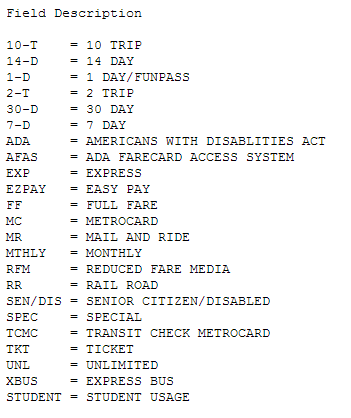

In [5]:
from __future__ import print_function, division
import pylab as pl
import numpy as np
import pandas as pd

from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import statsmodels.api as sm

%pylab inline

from IPython.display import Image
from IPython.display import clear_output
pl.rcParams['font.size'] = 20
Image(filename = "Ridetypes.png")

# read in data as instructed above

In [6]:
mta = np.load("MTA_Fare_py3.npy")

In [8]:
mta = mta.astype('float')

In [9]:
mta[mta<0] = np.nan

In [10]:
mta[np.isnan(mta)]

array([nan, nan, nan, ..., nan, nan, nan])

In [11]:
mta[mta<0]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


array([], dtype=float64)

In [12]:
print ("MTA array shape:", mta.shape)
print ("MTA array shape summed over all ride types:", np.nansum(mta,axis=1).shape)

MTA array shape: (600, 23, 194)
MTA array shape summed over all ride types: (600, 194)


create a "ride types" list based on the metadata I was given

In [13]:
#ridership type list
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])
print("number of ride types", len(ridetype))

number of ride types 23


You need to create a date range to plot properly. 
After that I create a date range (for example with pd.date_range())
in a log plot to enhance the visibility along the y axis (np.log10(weightedrides[i]))
all time series, each station each ride type, look like this (pretty ugly)

In [14]:
daterange = pd.date_range(start= '05/19/2010',periods=194, freq='W')

Text(0,0.5,'swipes(count)')

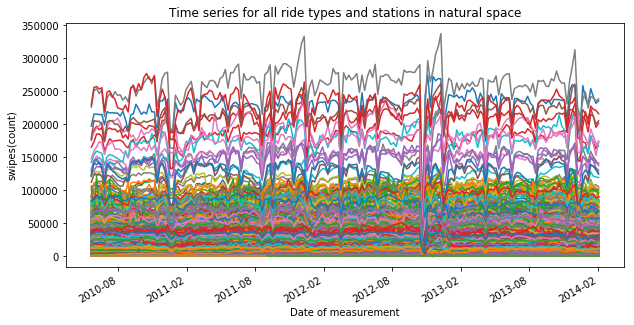

In [15]:
fig, ax = plt.subplots(figsize=(10,5))
for x in range(mta.shape[0]):
    for y in range(mta.shape[1]):
        plt.plot(daterange,(mta[x,y,:]))
plt.title('Time series for all ride types and stations in natural space')
ax.xaxis_date()     # interpret the x-axis values as dates
fig.autofmt_xdate()
plt.xlabel('Date of measurement')
plt.ylabel('swipes(count)')

#### Figure 1: The above plot shows the time series for all ride types and all stations in natural space i.e. 600 * 23 time series.

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


Text(0,0.5,'swipes(log10)')

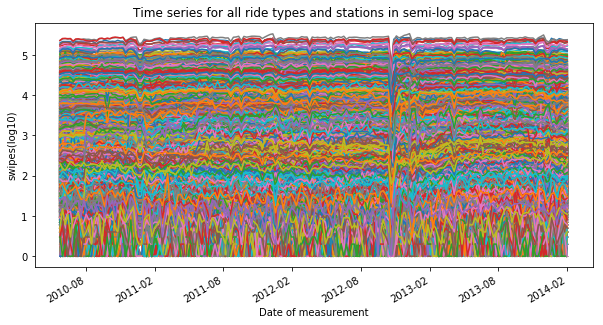

In [16]:
fig, ax = plt.subplots(figsize=(10,5))
for x in range(mta.shape[0]):
    for y in range(mta.shape[1]):
        plt.plot(daterange,np.log10(mta[x,y,:]))
plt.title('Time series for all ride types and stations in semi-log space')
ax.xaxis_date()     # interpret the x-axis values as dates
fig.autofmt_xdate()
plt.xlabel('Date of measurement')
plt.ylabel('swipes(log10)')

#### Figure 2: The above plot shows the time series for all ride types and all stations in semi-log space i.e. 600 * 23 time series. As we applied logarithm to the value, they are clustered more tightly than for the natural scale.

# 4. Fourier transform
from the numpy package you will nees only the 
np.fft.rfft() to take the fourier transform

and

np.fft.rfftfreq() to create a meaningful x axis 

In [118]:
# Dropping the card type axis
ride_station = np.nansum(mta,axis=1)

In [119]:
shape(ride_station) #checking the same

(600, 194)

#### Considering only 3 years of the data to get a better idea of the periodicity as incorporating only a partial 4th year will only skew the periodicity. Pablo explained this logic to me. (Each year has around 52 weeks as given above)

In [121]:
N = 52 *3 

In [122]:
(np.fft.rfft(ride_station,n=N).real)**2

array([[3.80666127e+14, 2.65065700e+12, 2.90383346e+10, ...,
        1.11405238e+09, 2.00924680e+10, 6.51491122e+09],
       [1.60682967e+13, 4.91829093e+11, 9.48895035e+10, ...,
        1.59072241e+09, 2.15214254e+07, 3.05786880e+09],
       [1.22979228e+12, 1.18717934e+09, 8.35443516e+08, ...,
        1.29134415e+07, 5.75835132e+07, 4.09600000e+03],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [124]:
# Calculating the fourier transform for the 600 time series
f = (np.fft.rfft(ride_station,n=N).real)**2

In [125]:
f.shape[0]

600

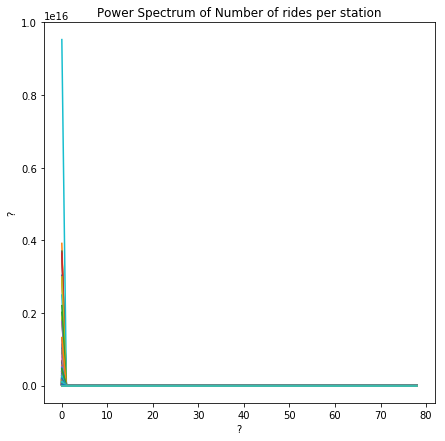

In [129]:
plt.figure(figsize=(7,7))
for i in range(f.shape[0]):

    pl.plot(f[i,]);
pl.title("Power Spectrum of Number of rides per station")
pl.title
pl.xlabel("?")
pl.ylabel("?");

### Figure 3: This is a plot of the fourier transform of the 600 time series. We can see here that the X-axis is not very interpretable, we cannot find out the index. So , I use the rttffreq() function to create a meaningful x-axis.

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


Text(0.5,1,'Power spectrum of the 600 time series')

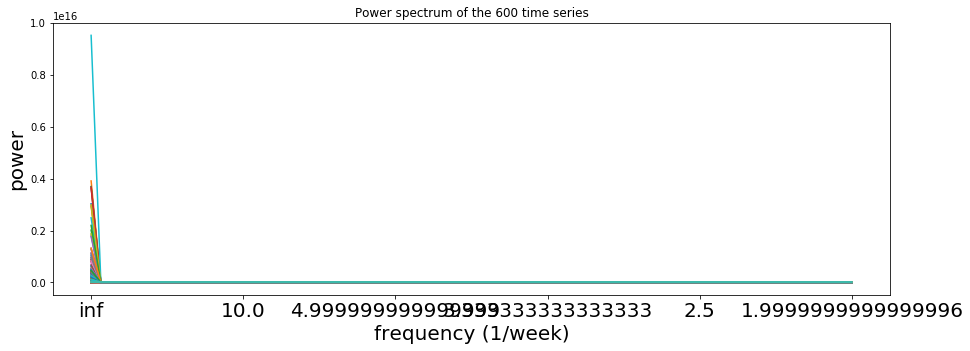

In [130]:
fig=pl.figure(figsize=(15,5))
ax=fig.add_subplot(111)
for i in range(f.shape[0]):
#     ax.plot(np.fft.rfftfreq(N ), (f[i,:]), 'o', ms=20)
    ax.plot(np.fft.rfftfreq(N, 1.0), (f[i,:]), '-')
ax.set_xticklabels([ "%s"%(1/f) for f in ax.get_xticks()], fontsize=20)
pl.ylabel("power", fontsize=20)
pl.xlabel("frequency (1/week)", fontsize=20);
plt.title('Power spectrum of the 600 time series')

### Figure 4: This is similar to the above plot the only difference being that the x-axis now has the sample frequencies of the Fourier with a sampling rate of 1 and the number of samples = 52 * 3 which is 156. This is to make the x-axis interpretable. Here, the plot is still unclear because the first point of all time series has the x-tick 1/0 which is inifinity. So, we do should replot this without the first point.

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys


Text(0.5,1,'Power spectrum of the 600 time series without infinity')

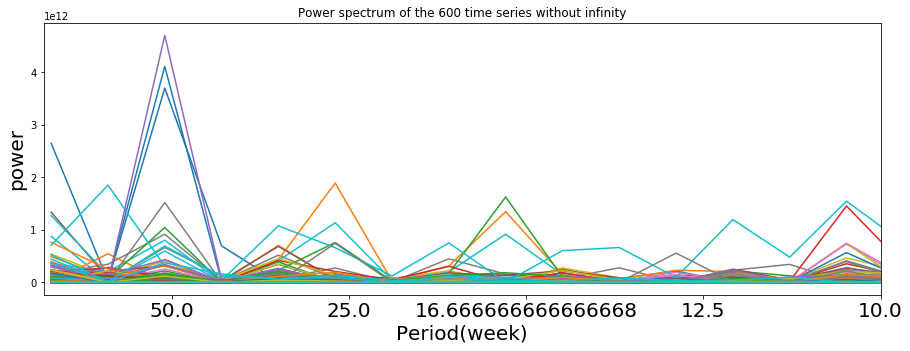

In [132]:
fig=pl.figure(figsize=(15,5))
ax=fig.add_subplot(111)
pl.xlim(1/180.0,1/10.0)
for i in range(f.shape[0]):
#     ax.plot(np.fft.rfftfreq(N)[1:], (f[i,1:]), 'o', ms=20)
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (f[i,1:]), '-')
ax.set_xticklabels([ "%s"%(1/f) for f in ax.get_xticks()], fontsize=20)
pl.ylabel("power", fontsize=20)
pl.xlabel("Period(week)", fontsize=20);
plt.title('Power spectrum of the 600 time series without infinity')

### Figure 5: As discussed above, I have plotted all the time series without the first point to get a better view as the 1/0 was making anything else almost impossible to notice. Also, I changed the x-axis to period instead of frequnecy which is in fact the inverse of frequency. Since we want the annual periodicity, we look for the time series with the highest power values at a period of 52. We can see in the plot that there are obviously 4 time series at that period with the highest values. So now, we need to find the station numbers(time series) with those values.

In [133]:
# Finding the index where period is 52(exactly 52 at index 4 in this case)
1/np.fft.rfftfreq(N)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


array([         inf, 156.        ,  78.        ,  52.        ,
        39.        ,  31.2       ,  26.        ,  22.28571429,
        19.5       ,  17.33333333,  15.6       ,  14.18181818,
        13.        ,  12.        ,  11.14285714,  10.4       ,
         9.75      ,   9.17647059,   8.66666667,   8.21052632,
         7.8       ,   7.42857143,   7.09090909,   6.7826087 ,
         6.5       ,   6.24      ,   6.        ,   5.77777778,
         5.57142857,   5.37931034,   5.2       ,   5.03225806,
         4.875     ,   4.72727273,   4.58823529,   4.45714286,
         4.33333333,   4.21621622,   4.10526316,   4.        ,
         3.9       ,   3.80487805,   3.71428571,   3.62790698,
         3.54545455,   3.46666667,   3.39130435,   3.31914894,
         3.25      ,   3.18367347,   3.12      ,   3.05882353,
         3.        ,   2.94339623,   2.88888889,   2.83636364,
         2.78571429,   2.73684211,   2.68965517,   2.6440678 ,
         2.6       ,   2.55737705,   2.51612903,   2.47

In [134]:
# Finding the station numbers corresponding to the top 4 power values
np.argsort(f[:,3])[::-1][:4]

array([194, 150,   0, 327])

In [135]:
top4 = np.argsort(f[:,3])[::-1][:4]

Text(0.5,1,'The most periodic top 4 time series')

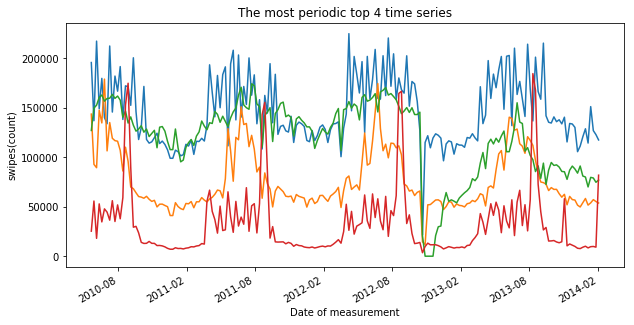

In [137]:
fig, ax = plt.subplots(figsize=(10,5))
for i in top4:
    plt.plot(daterange,ride_station[i,])
ax.xaxis_date()     
fig.autofmt_xdate()
plt.xlabel('Date of measurement')
plt.ylabel('swipes(count)')
plt.title('The most periodic top 4 time series')

### Figure 6: The plot shows the time series for the stations supposed to have the highest periodicity as per the Fourier transform values. And we can indeed see that the number of swipes are highly periodic for these. 

### Speculated Reason for periodicity: We can see that the number of card swipes are much higher during summer each year. We know that these are stations in Manhattan and it has to be places where people go more for recreation and not work related because if it was the place of work or study, they would have to go no matter what the season. I think this spike might be because more tourists come to NYC in summer and in fact, residents also tend to go out more to places like Central Park or Times Square,etc.